Primal problem:
$$\min c^T x \quad\text{subject to}\quad Ax=b, -x\leq 0.$$

Dual problem:
$$\max b^T y \quad\text{subject to}\quad A^Ty\leq c.$$

In [1]:
import numpy as np
from functions import newton_eq, plot_error_iter
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cp
from time import time
def cvx_solution(A, b, c):
    x = cp.Variable(n)
    obj = cp.Minimize(c@x)
    cons = [A@x == b, x >= 0]
    prob = cp.Problem(obj, cons)
    prob.solve(solver="MOSEK")
    return prob.value

def get_res(x, lambda_, v, tinv, grad_f):
    r_dual = Dh(x).dot(lambda_) + A.T.dot(v) + grad_f(x)
    r_cent = -np.diag(lambda_)@h(x) - tinv
    r_pri = A.dot(x)-b
    return r_dual, r_cent, r_pri

def get_res_norm(x, lambda_, v, tinv, grad_f):
    r_dual, r_cent, r_pri = get_res(x, lambda_, v, tinv, grad_f)
    return np.linalg.norm(r_dual), np.linalg.norm(r_cent), np.linalg.norm(r_pri)


def primal_dual(grad_f, h, Dh, H_pd, x0, A, b, mu, MAXITERS=100, TOL=1e-8,alpha = 0.01, beta = 0.8, RESTOL=1e-8):
    MAXITERS = MAXITERS
    TOL = TOL
    RESTOL = RESTOL
    mu = mu
    alpha = alpha
    beta = beta
    m, n = A.shape
    gaps = []
    resdls = []
    x = x0.copy()
    x_list = [x]
    h = h
    Dh = Dh
    H_pd = H_pd
    # Lagrange multiplier for inequality constraints
    lambda_ = -1 / (h(x))
    # Lagrange multiplier for equality constraints
    v = np.zeros(m)

    for iters in range(MAXITERS):
        # Surrogate duality gap
        eta = - h(x).dot(lambda_)
        gaps.append(eta)
        tinv = eta/(m*mu)

        r_dual, r_cent, r_pri = get_res(x, lambda_, v, tinv, grad_f)
        resdls.append(np.linalg.norm(np.hstack([r_dual, r_pri])))
        # stopping criterion
        if eta < TOL and resdls[-1] < RESTOL:
            break
        
        sol = -np.linalg.solve(
            np.block([[H_pd(x), Dh(x).T, A.T],
                    [-np.diag(lambda_)@Dh(x), -np.diag(h(x)), np.zeros((n, m))],
                    [A, np.zeros((m, m)), np.zeros((m, n))]]),
            np.hstack([r_dual, r_cent, r_pri])
        )
        dx = sol[:n]
        dlambda_ = sol[n:n+n]
        dv = sol[-m:]

        # backtracking line search
        # The maximum step such that the new lambda_ is positive, i.e., feasible.
        step = min(1, 0.99/np.max(-dlambda_/lambda_))
        while True:
            x_new = x + step*dx
            if np.all(h(x_new) < 0):
                break
            step *= beta
        new_x = x + step*dx
        new_lambda_ = lambda_ + step*dlambda_
        new_v = v + step*dv
        # Old residual norm
        old_norm = sum(get_res_norm(x, lambda_, v, tinv, grad_f))

        while sum(get_res_norm(new_x, new_lambda_, new_v, tinv, grad_f)) > (1- alpha * step) * old_norm:
            step *= beta
            new_x = x + step*dx
            new_lambda_ = lambda_ + step*dlambda_
            new_v = v + step*dv

        x = new_x
        lambda_ = new_lambda_
        v = new_v
        x_list.append(x)
    return x_list


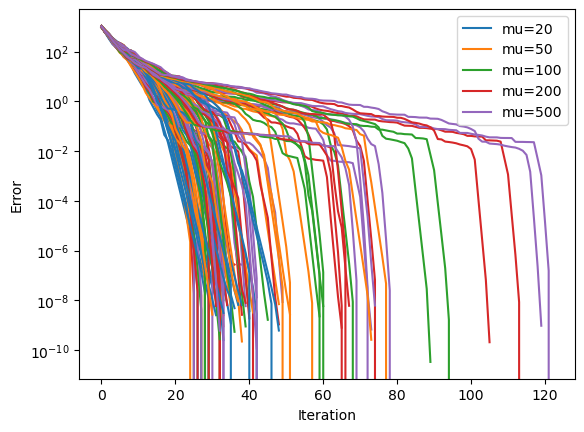

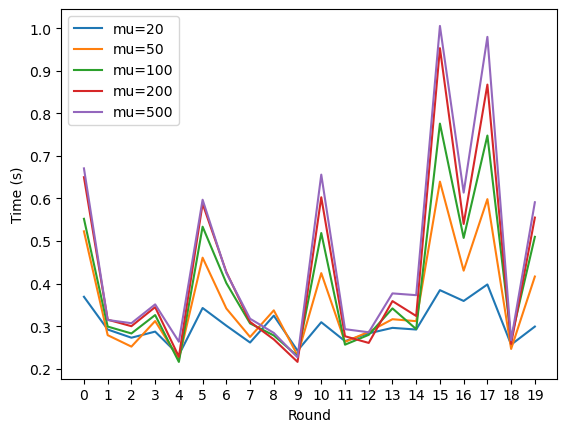

In [2]:
# m: number of constraints
# n: number of variables
m = 100
n = 500

np.random.seed(0)
rounds=20
mu_list = [20, 50, 100, 200, 500]
# get matplot colors map for mu_list
# colors = matplotlib.colormaps.get_cmap('cool')(np.linspace(0, 1, len(mu_list)))
colors = list(matplotlib.colormaps.get_cmap('tab10').colors[:len(mu_list)])
time_consumed = np.zeros((rounds,len(mu_list)))
iters = 0
while iters < rounds:
    A = np.random.randn(m, n)
    x0 = np.random.random(n)
    b = A.dot(x0)
    z = np.random.randn(m)
    s = 10*np.random.random(n)

    # This is to make sure that the dual problem is feasible in interior since A.T @ z < c.
    c = A.T.dot(z) + s
    sol = cvx_solution(A, b, c)
    grad_f = lambda x: c
    h = lambda x: -x
    Dh = lambda x: -np.eye(len(x))
    H_pd = lambda x: np.zeros((len(x), len(x)))
    for index, mu in enumerate(mu_list):
        start_time = time()
        x_list = primal_dual(grad_f, h, Dh, H_pd, x0.copy(), A, b, mu, MAXITERS=500, TOL=1e-8,alpha = 0.01, beta = 0.8, RESTOL=1e-8)
        end_time = time()
        time_consumed[iters, index] = end_time-start_time
        plot_error_iter(x_list@c, sol, label="mu=%d"%mu, color=colors[index])
        
    iters += 1

    
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend(["mu=%d"%mu for mu in mu_list])
plt.savefig("./figure/primal_dual_%d_%d.png"%(m,n))
plt.show()

for index, mu in enumerate(mu_list):
    plt.plot(time_consumed[:,index], color=colors[index])
plt.xticks(np.arange(0, 20, 1))
plt.xlabel("Round")
plt.ylabel("Time (s)")
plt.legend(["mu="+str(mu) for mu in mu_list])
plt.savefig("./figure/primal_dual_%d_%d_time.png"%(m,n))
plt.show()
